In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
import io

plt.rcParams["figure.figsize"] = (10,10)



### *Importing files from github for google colab


In [2]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [3]:
N =500# Number of nodes
setting='home'    #the setting we are evaluating(home,work,school,other)
D=50#number of days the model runs
increase_ratio=50 #the rate of increasing weight per contact
lower_weight=0  #the minimum weight between two node
threshold_n=1     #threshold of product weight two nodes with same neighbor for increasing weight
increse_rate_n=0  #increse rate weight for two nodes with same neighbor

## 1-Defining Nodes

In [4]:
G = nx.DiGraph()

In [5]:
#defining a dictionary of nodes
available_groups  = [] #16_age_groups
group_popularity = [] #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict()


for i, row in population_df.iterrows():
    
    available_groups.append(row[0])
    group_popularity.append(float(row[1]))
    

for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
                    
for i in range(N):
    while True:
        r=random.random()
        t=random.randint(0,15)
        if r<=group_popularity[t]:
            nodes_dic[f'n{i+1}']={'age':available_groups[t]}
            break


for i in range(N):
    a=v_prevalence[nodes_dic[f'n{i+1}']['age']][0]
    b=v_prevalence[nodes_dic[f'n{i+1}']['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[f'n{i+1}']['infection']=1
    else:
        nodes_dic[f'n{i+1}']['infection']=0
        

In [6]:
#importing data for frequency of contact in each setting for comparison
frequency=dict()

for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [7]:

# let's see the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'15_19': 22,
 '50_54': 35,
 '40_44': 39,
 '0_4': 46,
 '75+': 6,
 '5_9': 42,
 '35_39': 38,
 '55_59': 21,
 '30_34': 51,
 '70_74': 11,
 '10_14': 37,
 '45_49': 37,
 '25_29': 56,
 '20_24': 38,
 '60_64': 9,
 '65_69': 12}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [8]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()     

## 3-Defining Rules to Connecting Nodes and Adjusting `Probabilities/Distances`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [9]:
#in this block we've defiend a function "Run" 
def Run(increase_rate,threshold_n,increse_rate_n,D):
    
    x_upped=0
    x_downed=0
    
    #building the graph based on nodes_dic
    
    for i in nodes_dic.keys():
        for j in nodes_dic.keys():
            if i!=j and rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]!=0:
                              
               #this condition determine if a node is added to graph or not based on setting 
                G.add_edge(i,j,weight=1)
     #counting number of each age group in graph  
    group_count = {}
    for n in nx.nodes(G):
    
        if nodes_dic[n]['age'] in group_count:
            group_count[nodes_dic[n]['age']] = group_count[nodes_dic[n]['age']] + 1
        else:
            group_count[nodes_dic[n]['age']] = 1
            
            
    
    #bulding empty dictinary "contacted" for storing contacts in single day
    #building empty dictionary for monitoring all contacts during all days
    #building empty dictionary for monitoring all weights during all days
    contacted={}
    #contacted_all={}
    #weight_all={} 
    #decreae_rates_dict={}
    contacted_history={}
    
    for i in nx.edges(G):
        
        if i[0] in contacted.keys():
            contacted[i[0]][i[1]]=0
            contacted_history[i[0]][i[1]]=0
            #contacted_all[i[0]][i[1]]=[]
            #weight_all[i[0]][i[1]]=[]
            #decreae_rates_dict[i[0]][i[1]]=[]
                 
        else :
            contacted[i[0]]={i[1]:0}
            contacted_history[i[0]]={i[1]:0}
            #contacted_all[i[0]]={i[1]:[]}
            #weight_all[i[0]]={i[1]:[]}
            #decreae_rates_dict[i[0]]={i[1]:[]}
    #determinig upper_weight and increase_rate based on age of contacor and contactee
    weight_factors={}
    for i in available_groups:
        weight_factors[i]={}
        for j in available_groups:
            weight_factors[i][j]={}
            age_p=rules[setting][i][j]
            weight_factors[i][j]['upper_weight']=1/age_p*(group_count[i]-age_p)
            weight_factors[i][j]['increase_rate']=weight_factors[i][j]['upper_weight']/increase_ratio
            
    for d in range (0,D):#we are running the model for D days
        
        #building a dictionary that includes number of 'weight addition' and number of nodes viable for 'weight substraction'
        N_contacted=dict()
        for i in nx.nodes(G):
            N_contacted[i]={}
            for j in group_count.keys():
                N_contacted[i][j]={'N_base':0,'N_c':0,'decrease_rate':0,'N_c_T':0 }
                               
        #iterating thorough the graph and storing connections in 'contacted'
        for i in nx.edges(G):
                                   
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            r=random.random()
            
            if r <(age_p/group_count[nodes_dic[i[1]]['age']])*G.edges[i[0],i[1]]['weight']:
                contacted[i[0]][i[1]]=1
                contacted_history[i[0]][i[1]]=1
                #contacted_all[i[0]][i[1]].append(1)#storing contacts of each run in this dic
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c_T']+=1#Number of edges that had connection
            else:
                contacted[i[0]][i[1]]=0
                #contacted_all[i[0]][i[1]].append(0)
                               
        # iterating thorough 'contacted' and adding to the weights based on it
        for i in nx.edges(G):
            
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            
            upper_weight=weight_factors[nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]['upper_weight']
            increase_rate=weight_factors[nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]['increase_rate']
           
            if contacted[i[0]][i[1]]==1 and G[i[0]][i[1]]['weight']+increase_rate <=upper_weight:
                #we don't want the weight to be more than 'upper weight'
                
                


                t=G[i[0]][i[1]]['weight']+increase_rate
                G.add_edge(i[0],i[1],weight=t)
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c']+=1#number of edges with connection AND increase weight
            if G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']<lower_weight:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_base']+=1
         
        #we calculate how much weight is added overall,and then distrubt it between all nodes that should decrease weight
        for i in nx.edges(G):
            
            increase_rate=weight_factors[nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]['increase_rate']
            
            N_base= N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_base']
            N_c=N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c']
            N_c_T=N_contacted[i[0]][nodes_dic[i[1]]['age']]['N_c_T']
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            pop=group_count[nodes_dic[i[1]]['age']]-N_base-N_c_T
            
            if pop!=0:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']=(increase_rate*N_c)/pop
            else:
                N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']=0
                
                
                
            
            if contacted[i[0]][i[1]]==0 and (G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate'] >=lower_weight):
                #we don't want the weight to be lower than lower_weight
                t=G[i[0]][i[1]]['weight']-N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate']
                G.add_edge(i[0],i[1],weight=t)
            #weight_all[i[0]][i[1]].append(G.edges[i[0],i[1]]['weight'])
            
            #decreae_rates_dict[i[0]][i[1]].append(N_contacted[i[0]][nodes_dic[i[1]]['age']]['decrease_rate'])

        #updating weight between two nodes with same neighbor
        #for i in nodes_dic.keys():
            #for j in nodes_dic.keys():
                #if i!=j:
                    #for o in nodes_dic.keys():
                        #if o!=j and o!=i:

                            #if (G[i][o]['weight']*G[i][j]['weight'])>threshold_n and G[o][j]['weight']<1:
                                #t=G[o][j]['weight']+increse_rate_n
                                #G.add_edge(i,j,weight=t)
    return(contacted_history,G,group_count,weight_factors,contacted)


# 4- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [10]:
#this function returns p_value wilcoxon for comparison age stratified number of contacts 
   

def metric_A_wilx(results) :   

    
    G=results[1]
    group_count=results[2]
    contacted=results[4]

    L1=[]
    L2=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0

    for i in nx.edges(G):   
        
            age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
            t=(age_p/(group_count[nodes_dic[i[1]]['age']]*group_count[nodes_dic[i[0]]['age']]))*G.edges[i[0],i[1]]['weight']
            rules_m[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]+=t
       
            
   
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])

    I=stats.wilcoxon(L1,L2, zero_method='wilcox', correction=False, alternative='two-sided')
    return(I,rules_m)

In [11]:
#this function returns the absoloute error for age stratified number of contact

def metric_A_abs(results):
    
    L=[]

    
    G=results[1]
    group_count=results[2]
    contacted=results[4]

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    for i in nx.edges(G):   
        
        age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
        t=(age_p/(group_count[nodes_dic[i[1]]['age']]*group_count[nodes_dic[i[0]]['age']]))*G.edges[i[0],i[1]]['weight']
        rules_m[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]['age']]+=t


    

    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():

                L.append(abs((rules_m[setting][i][j])-(rules[setting][i][j])))

    I=statistics.mean(L)
    return(I,rules_m)

In [12]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(results):
    
    n=0
    
    
    contacted_history=results[0]
    G=results[1]
    group_count=results[2]
    contacted=results[4]
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0,5:0}

    for i in nx.edges(G):
            if contacted[i[0]][i[1]]==1:
                
                age_p=rules[setting][nodes_dic[i[0]]['age']][nodes_dic[i[1]]["age"]]
        
                t=(age_p/group_count[nodes_dic[i[0]]['age']])*G.edges[i[0],i[1]]['weight']

                n+=1

                if contacted_history[i[0]][i[1]]==1 and t<(1/30) :
                    frequency_m[setting][4]+=1

                elif t>=(1/30) and t<=(2/30):
                    frequency_m[setting][3]+=1

                elif t>(2/30) and t <=(2/7):
                    frequency_m[setting][2]+=1

                elif t>(2/7):

                    frequency_m[setting][1]+=1
                else:
                    frequency_m[setting][5]+=1

    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
        
            
        
    
    for i in frequency_m[setting].keys():
        
        L1.append(frequency[setting][i])
        L2.append(frequency_m[setting][i])
    
    #print('for the first time:',frequency_m[setting][5],'\nless than once a month:',frequency_m[setting][4],'\nabout once or twice a month:',frequency_m[setting][3],'\nabout once or twice a week',frequency_m[setting][2],'\ndaily or almost daily',frequency_m[setting][1])

    return(frequency_m)

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_rate, threshold_n, increse_rate_n, D 
###### Run -> output : contacted_all, G, weight_all, group_count


In [13]:
#this part runs the model
results=Run(increase_ratio,threshold_n,increse_rate_n,D )


In [14]:
#this part returns the absoloute error for age stratified number of contact
M_abs=metric_A_abs(results)
print(M_abs[0])

0.25160823414580774


In [15]:
#this part shows number of age stratified contact from data and model for comparision
for i in rules[setting].keys():
    for j in rules[setting][i].keys():
        print(i,'->',j,M_abs[1][setting][i][j],'//',rules[setting][i][j])

0_4 -> 0_4 0.47307246669833375 // 0.43913
0_4 -> 5_9 0.7837127111469792 // 0.70013
0_4 -> 10_14 0.5834117128439128 // 0.45382
0_4 -> 15_19 0.8562237898259449 // 0.25108
0_4 -> 20_24 0.522297731867737 // 0.41814
0_4 -> 25_29 0.5960872041834682 // 0.58958
0_4 -> 30_34 0.5830520371768688 // 0.56166
0_4 -> 35_39 0.58305837053461 // 0.44455
0_4 -> 40_44 0.3085036198744768 // 0.24272
0_4 -> 45_49 0.21002478984410372 // 0.12269
0_4 -> 50_54 0.23673045711627771 // 0.1481
0_4 -> 55_59 0.6466554150348696 // 0.13615
0_4 -> 60_64 3.625992872325722 // 0.08664
0_4 -> 65_69 1.1368438326284456 // 0.04243
0_4 -> 70_74 0.3861190478260861 // 0.01513
0_4 -> 75+ 1.7509347536231978 // 0.01275
10_14 -> 0_4 0.2949280579342191 // 0.29022
10_14 -> 5_9 0.5982937791546035 // 0.58282
10_14 -> 10_14 0.8294135605136072 // 0.79402
10_14 -> 15_19 0.7540674443227253 // 0.4293
10_14 -> 20_24 0.16954438769494737 // 0.12883
10_14 -> 25_29 0.12165218647647771 // 0.11601
10_14 -> 30_34 0.2367726711173133 // 0.23366
10_14 ->

In [16]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('%f' % metric_A_wilx(results)[0][1])

0.000000


In [17]:
#this shows the mean of all edeges across the graph(it's supposed to stay close to one)
mean_weights=[]
for i in nx.edges(results[1]):
             
    mean_weights.append(results[1].edges[i[0],i[1]]['weight'])
            
print(statistics.mean(mean_weights))

4.3119530915091655


home : 1 // 0.22514868309260833 // 0.7030300218
home : 2 // 0.45879354290569246 // 0.154702798
home : 3 // 0.24242424242424243 // 0.09122546518
home : 4 // 0.0736335315774568 // 0.03693564104
home : 5 // 0.0 // 0.01410607396


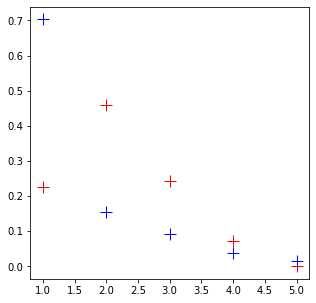

In [18]:
#this shows the fitting for frequency
results_F=metric_F(results)

plt.rcParams["figure.figsize"] = (5,5)

for i in results_F[setting].keys():
    print (setting,':',i,'//',results_F[setting][i],'//',frequency[setting][i])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,frequency[setting][i],'+b',linewidth=1, markersize=12,alpha=1)

plt.show()
